# ChromVAR

Run ChromVAR for OSKM selected motifs only.

In [179]:
library(chromVAR)
library(TFBSTools)
library(BSgenome.Hsapiens.UCSC.hg38)
library(Matrix)
library(SummarizedExperiment)
library(patchwork)
library(ggplot2)
library(scales)
library(BiocParallel)
set.seed(2017)

In [2]:
register(MulticoreParam(20, progressbar = TRUE))

## Load Data

In [4]:
pmat = readMM("../20200206_pmat_snapATAC/sessions/20201022_n53906/pmat.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  53906 414473

In [5]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20201022_n53906/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
dim(metaData)
head(metaData, 5)

[1] 53906     6

,barcode,sample,umap1,umap2,cluster,cells
,<fct>,<fct>,<dbl>,<dbl>,<int>,<chr>
D0_AACGCGAGAAGGACCA,AACGCGAGAAGGACCA,D0,8.373301,-4.292619,5,D0_AACGCGAGAAGGACCA
D0_AACGCGCTGTCTGTGA,AACGCGCTGTCTGTGA,D0,2.033609,-7.860645,5,D0_AACGCGCTGTCTGTGA
D0_ACCTATGGACTCGATA,ACCTATGGACTCGATA,D0,3.093788,-7.469210,5,D0_ACCTATGGACTCGATA
D0_ACGCAGAGATAACCCA,ACGCAGAGATAACCCA,D0,6.001364,-7.523576,5,D0_ACGCAGAGATAACCCA
D0_ACTCGCTACTTGTGAC,ACTCGCTACTTGTGAC,D0,3.343237,-8.114589,5,D0_ACTCGCTACTTGTGAC


In [6]:
regions = read.table("../20200206_pmat_snapATAC/sessions/20201022_n53906/peaks.bed")
names(regions) = c("chr", "bp1", "bp2")
regions$site_name <- paste(regions$chr, regions$bp1, regions$bp2, sep="_")
row.names(regions) <- regions$site_name
dim(regions)
head(regions)

[1] 414473      4

,chr,bp1,bp2,site_name
,<fct>,<int>,<int>,<chr>
chr1_10268_10885,chr1,10268,10885,chr1_10268_10885
chr1_41988_42505,chr1,41988,42505,chr1_41988_42505
chr1_46058_46558,chr1,46058,46558,chr1_46058_46558
chr1_48200_48959,chr1,48200,48959,chr1_48200_48959
chr1_51306_52190,chr1,51306,52190,chr1_51306_52190
chr1_58644_59144,chr1,58644,59144,chr1_58644_59144


In [7]:
peaks_gr = GRanges(sub("_", "-", sub("_", ":", rownames(regions))))
peaks_gr

GRanges object with 414473 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1       10268-10885      *
       [2]     chr1       41988-42505      *
       [3]     chr1       46058-46558      *
       [4]     chr1       48200-48959      *
       [5]     chr1       51306-52190      *
       ...      ...               ...    ...
  [414469]     chrY 25399010-25399553      *
  [414470]     chrY 25410561-25411061      *
  [414471]     chrY 26220958-26221458      *
  [414472]     chrY 26315008-26315508      *
  [414473]     chrY 26670870-26671408      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [8]:
# binarize the matrix (could also do outlier removal)
pmat@x[pmat@x > 0] <- 1

In [9]:
pmatRowSums = Matrix::rowSums(pmat)

In [10]:
pmatColSums = Matrix::colSums(pmat)

In [11]:
min(pmatRowSums)

[1] 222

In [12]:
min(pmatColSums)

[1] 15

## Motif Hits Matrix

In [160]:
TAKE_TOP = 50000

In [161]:
OCT4_motif_gr = import("./data/20201022_n53906/POU5F1_MA1115.1.all_peaks.bed")
OCT4_motif_gr = OCT4_motif_gr[rev(order(OCT4_motif_gr$score))[1:TAKE_TOP], ]
OCT4_motif_gr

GRanges object with 50000 ranges and 2 metadata columns:
          seqnames              ranges strand |            name         score
             <Rle>           <IRanges>  <Rle> |     <character>     <numeric>
      [1]     chrY   18690595-18690605      - | POU5F1_MA1115.1 9.62120866557
      [2]     chrY   18682753-18682763      - | POU5F1_MA1115.1 9.62120866557
      [3]     chrY   18637637-18637647      + | POU5F1_MA1115.1 9.62120866557
      [4]     chrY   18629795-18629805      + | POU5F1_MA1115.1 9.62120866557
      [5]     chrY   15440299-15440309      - | POU5F1_MA1115.1 9.62120866557
      ...      ...                 ...    ... .             ...           ...
  [49996]     chr7 106144286-106144296      - | POU5F1_MA1115.1 8.31113815706
  [49997]     chr7 106015617-106015627      - | POU5F1_MA1115.1 8.31113815706
  [49998]     chr7 105918871-105918881      - | POU5F1_MA1115.1 8.31113815706
  [49999]     chr7 105056495-105056505      - | POU5F1_MA1115.1 8.31113815706
  [5000

In [162]:
SOX2_motif_gr = import("./data/20201022_n53906/SOX2_HUMAN.H11MO.0.A.all_peaks.bed")
SOX2_motif_gr = SOX2_motif_gr[rev(order(SOX2_motif_gr$score))[1:TAKE_TOP], ]
SOX2_motif_gr

GRanges object with 50000 ranges and 2 metadata columns:
          seqnames              ranges strand |                 name
             <Rle>           <IRanges>  <Rle> |          <character>
      [1]     chrX 132045390-132045402      - | SOX2_HUMAN.H11MO.0.A
      [2]     chrX   22314647-22314659      + | SOX2_HUMAN.H11MO.0.A
      [3]     chr9 134215251-134215263      - | SOX2_HUMAN.H11MO.0.A
      [4]     chr9 115514575-115514587      - | SOX2_HUMAN.H11MO.0.A
      [5]     chr9   32194629-32194635      - | SOX2_HUMAN.H11MO.0.A
      ...      ...                 ...    ... .                  ...
  [49996]    chr12   72228548-72228560      + | SOX2_HUMAN.H11MO.0.A
  [49997]    chr11   34797370-34797382      - | SOX2_HUMAN.H11MO.0.A
  [49998]    chr11     6687671-6687683      - | SOX2_HUMAN.H11MO.0.A
  [49999]    chr10 128201927-128201939      - | SOX2_HUMAN.H11MO.0.A
  [50000]    chr10   34977457-34977469      - | SOX2_HUMAN.H11MO.0.A
                  score
              <numeric

In [163]:
KLF4_motif_gr = import("./data/20201022_n53906/KLF4_HUMAN.H11MO.0.A.all_peaks.bed")
KLF4_motif_gr = KLF4_motif_gr[rev(order(KLF4_motif_gr$score))[1:TAKE_TOP], ]
KLF4_motif_gr

GRanges object with 50000 ranges and 2 metadata columns:
          seqnames              ranges strand |                 name
             <Rle>           <IRanges>  <Rle> |          <character>
      [1]     chrY   12644247-12644256      - | KLF4_HUMAN.H11MO.0.A
      [2]     chrY   12502258-12502267      - | KLF4_HUMAN.H11MO.0.A
      [3]     chrX 154547363-154547372      + | KLF4_HUMAN.H11MO.0.A
      [4]     chrX 154516241-154516250      + | KLF4_HUMAN.H11MO.0.A
      [5]     chrX 154486725-154486734      - | KLF4_HUMAN.H11MO.0.A
      ...      ...                 ...    ... .                  ...
  [49996]    chr15   83777051-83777060      - | KLF4_HUMAN.H11MO.0.A
  [49997]    chr15   83571998-83572007      - | KLF4_HUMAN.H11MO.0.A
  [49998]    chr15   83447715-83447724      + | KLF4_HUMAN.H11MO.0.A
  [49999]    chr15   83112499-83112508      + | KLF4_HUMAN.H11MO.0.A
  [50000]    chr15   83046900-83046909      + | KLF4_HUMAN.H11MO.0.A
                  score
              <numeric

In [164]:
MYC_motif_gr = import("./data/20201022_n53906/MYC_HUMAN.H11MO.0.A.all_peaks.bed")
MYC_motif_gr = MYC_motif_gr[rev(order(MYC_motif_gr$score))[1:TAKE_TOP], ]
MYC_motif_gr

GRanges object with 50000 ranges and 2 metadata columns:
          seqnames              ranges strand |                name
             <Rle>           <IRanges>  <Rle> |         <character>
      [1]     chrY   14602012-14602022      - | MYC_HUMAN.H11MO.0.A
      [2]     chr9 137740595-137740605      + | MYC_HUMAN.H11MO.0.A
      [3]     chr9 136741158-136741168      + | MYC_HUMAN.H11MO.0.A
      [4]     chr9 134422883-134422893      + | MYC_HUMAN.H11MO.0.A
      [5]     chr9 130984152-130984162      - | MYC_HUMAN.H11MO.0.A
      ...      ...                 ...    ... .                 ...
  [49996]     chr3   55658930-55658940      + | MYC_HUMAN.H11MO.0.A
  [49997]     chr3   52154888-52154898      + | MYC_HUMAN.H11MO.0.A
  [49998]     chr3   43734244-43734254      + | MYC_HUMAN.H11MO.0.A
  [49999]     chr3   23184062-23184072      - | MYC_HUMAN.H11MO.0.A
  [50000]     chr3   16101973-16101983      + | MYC_HUMAN.H11MO.0.A
                  score
              <numeric>
      [1] 1

In [166]:
dim(pmat)

[1]  53906 414473

In [167]:
motif_hits_matrix = matrix(0, length(peaks_gr), 4)
colnames(motif_hits_matrix) = c("POU5F1", "SOX2", "KLF4", "MYC")

motif_hits_matrix[unique(queryHits(findOverlaps(peaks_gr, OCT4_motif_gr))), 1] = 1
motif_hits_matrix[unique(queryHits(findOverlaps(peaks_gr, SOX2_motif_gr))), 2] = 1
motif_hits_matrix[unique(queryHits(findOverlaps(peaks_gr, KLF4_motif_gr))), 3] = 1
motif_hits_matrix[unique(queryHits(findOverlaps(peaks_gr, MYC_motif_gr))), 4] = 1

In [168]:
colSums(motif_hits_matrix)

POU5F1   SOX2   KLF4    MYC 
 45568  45879  36234  40715

## ChromVAR

In [169]:
GENOME = BSgenome.Hsapiens.UCSC.hg38

In [170]:
rse <- SummarizedExperiment(
                 assays = list(counts = t(pmat)), 
                 rowRanges = peaks_gr, 
                 colData = DataFrame(Cell_Type=1:nrow(pmat), depth=pmatRowSums)
    );

In [171]:
rse <- addGCBias(rse, genome = GENOME);

In [172]:
dev <- computeDeviations(object = rse, annotations = motif_hits_matrix)

  |======================================================================| 100%



In [173]:
dev_mat = t(assay(dev))

In [174]:
colnames(dev_mat) = colnames(motif_hits_matrix)
rownames(dev_mat) = rownames(metaData)
head(dev_mat)

,POU5F1,SOX2,KLF4,MYC
D0_AACGCGAGAAGGACCA,-0.1509006,-0.02867789,-0.06773534,-0.002706278
D0_AACGCGCTGTCTGTGA,-0.1507773,-0.05342948,-0.05475705,-0.028081874
D0_ACCTATGGACTCGATA,-0.1569081,-0.04314643,-0.03866246,0.023401176
D0_ACGCAGAGATAACCCA,-0.1442246,-0.06900680,-0.06142933,-0.001843167
D0_ACTCGCTACTTGTGAC,-0.1283466,-0.12835569,-0.12708557,-0.103474032
D0_AGACTACTGGCAGTTT,-0.1275711,-0.07020730,-0.06762387,-0.030886109


In [200]:
# save output
write.table(dev_mat, file="./sessions/20201022_n53906/OSKM_ChromVAR_dev_top50k_hits.tsv", quote=F, row.names=T, sep='\t')

In [176]:
variability <- computeVariability(dev)

  |======================================================================| 100%



In [177]:
variability

,name,variability,bootstrap_lower_bound,bootstrap_upper_bound,p_value,p_value_adj
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
POU5F1,POU5F1,4.6886180,4.6651814,4.713795,0,0
SOX2,SOX2,2.3726904,2.3586382,2.387962,0,0
KLF4,KLF4,3.2987177,3.2782030,3.320357,0,0
MYC,MYC,0.9465193,0.9403805,0.952341,1,1


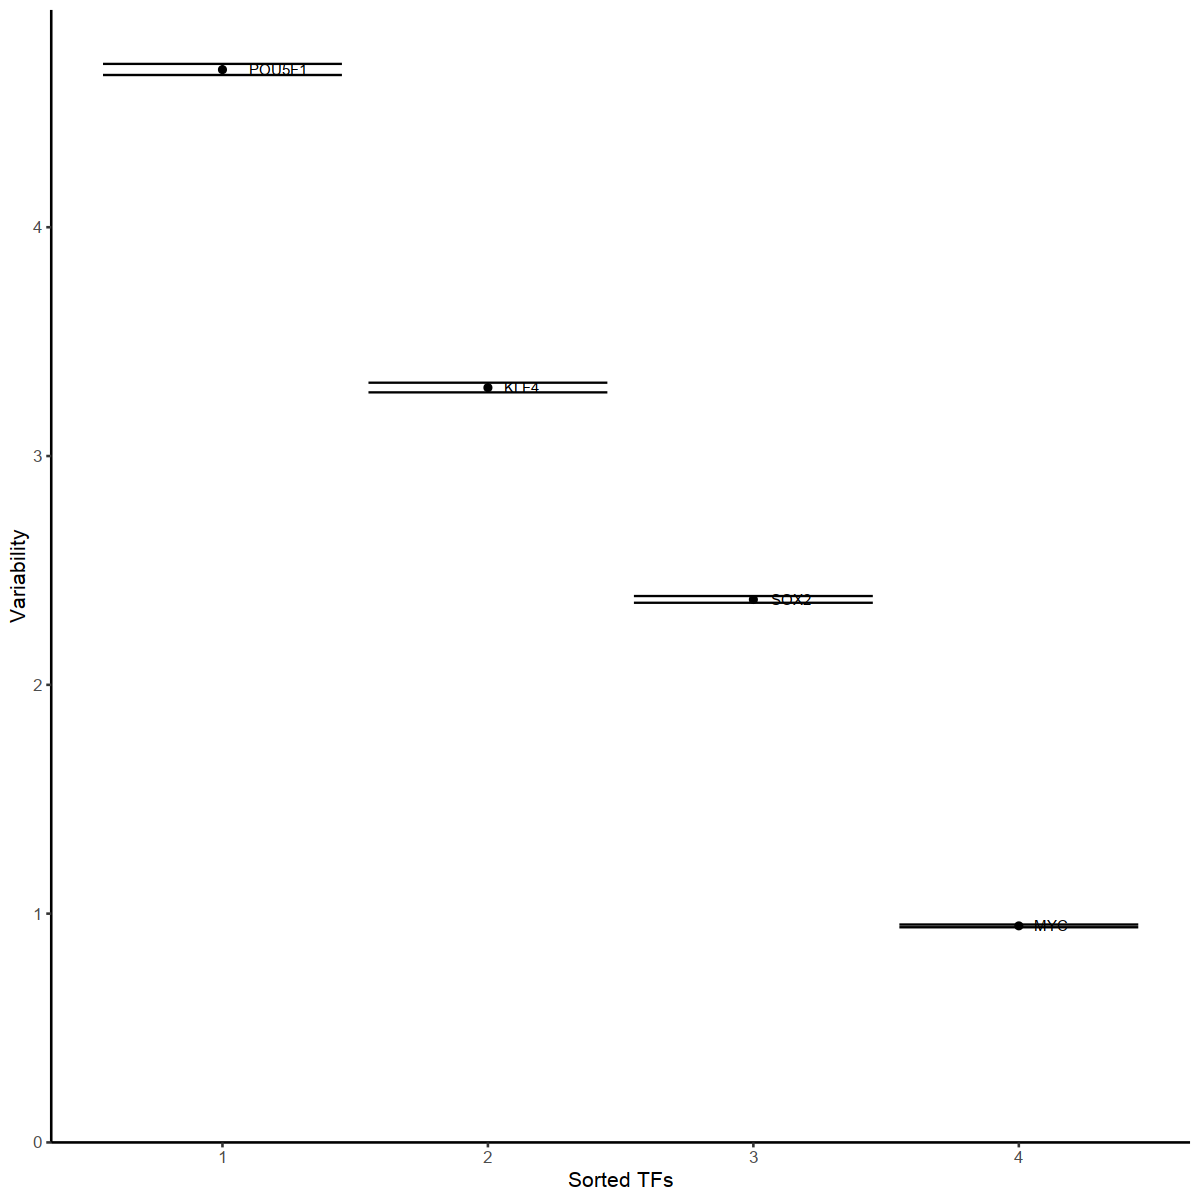

In [178]:
plotVariability(variability, use_plotly = FALSE, n = 20) 

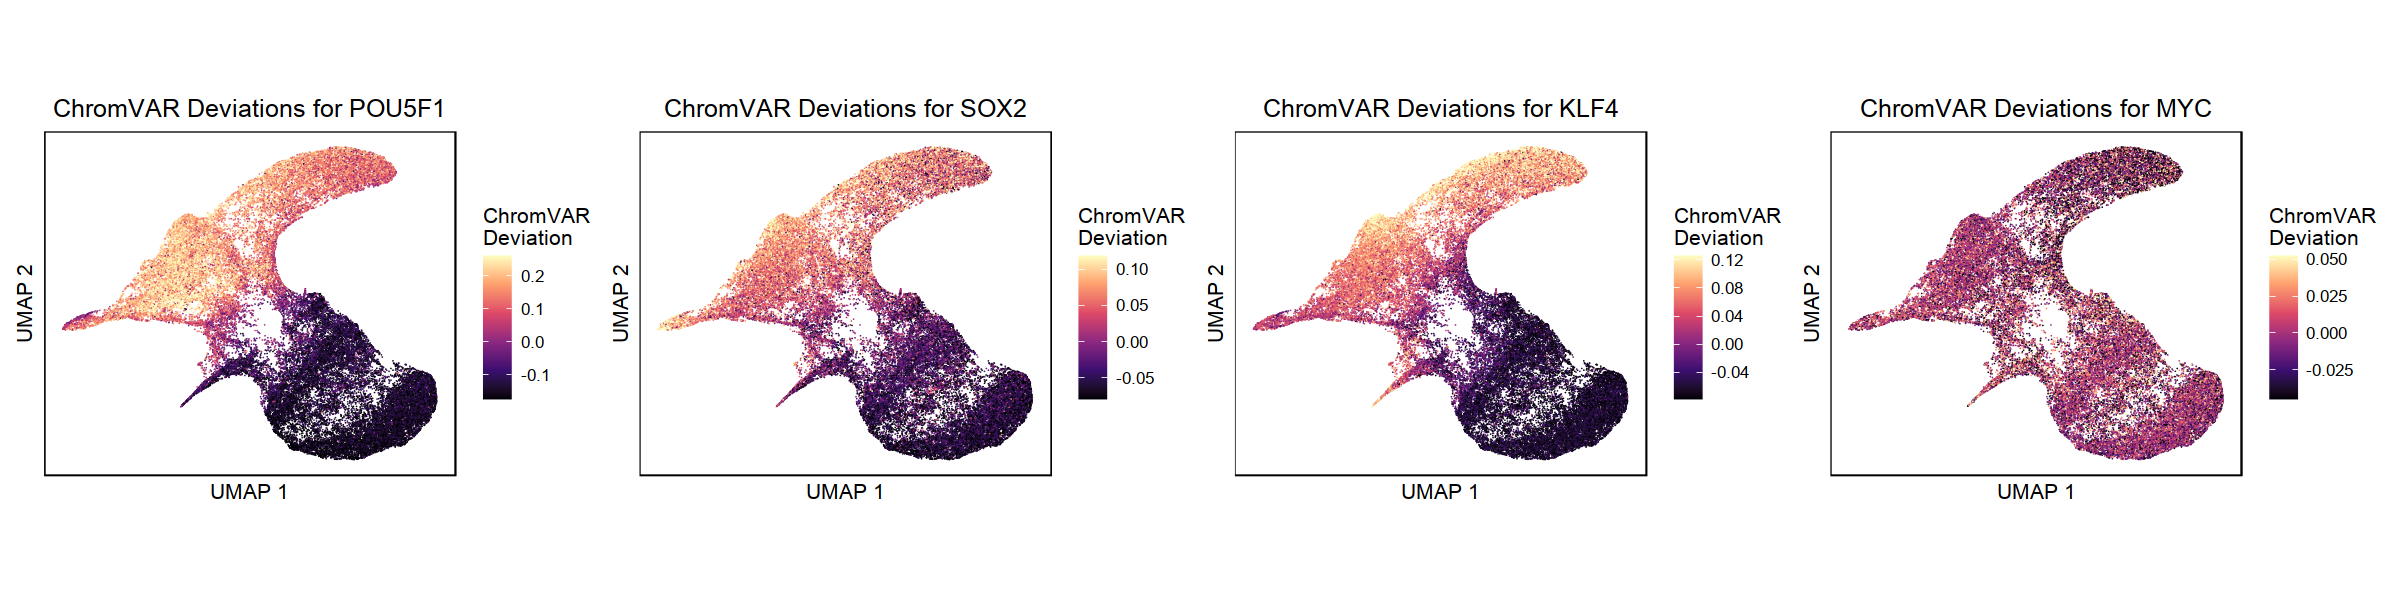

In [203]:
options(repr.plot.width = 20, repr.plot.height = 5)

chromvar_plots = list()

for (i in seq(ncol(motif_hits_matrix))) {
    cur_pattern = colnames(motif_hits_matrix)[i]
    cur_dev = dev_mat[,cur_pattern]

    df = data.frame(metaData, n=cur_dev)
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1]), ]

    cur_plot <- ggplot(df) +
    geom_point(size=0.2, stroke=0, alpha=1, aes(x=umap1 , y=umap2, col=n)) +
    scale_color_viridis_c(limit=c(quantile(cur_dev, 0.1),
                                  quantile(cur_dev, 0.95)), 
                          oob = squish, name='ChromVAR\nDeviation',
                         option="A") +
    ggtitle(sprintf("ChromVAR Deviations for %s", cur_pattern)) + 
    theme_classic() +
        xlab("UMAP 1") + ylab("UMAP 2") +
    theme(plot.title = element_text(hjust = 0.5),
              text = element_text(size=12),
              axis.line=element_blank(),
              axis.text.x=element_blank(),
              axis.text.y=element_blank(),
              axis.ticks=element_blank(),
              panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
    coord_fixed()
    
    chromvar_plots[[i]] = cur_plot

}

wrap_plots(chromvar_plots, nrow=1)

In [185]:
frips = list()
cors = c()

for (i in seq(ncol(motif_hits_matrix))) {
    cur_pattern = colnames(motif_hits_matrix)[i]
    
    frips[[i]] = 100*Matrix::rowSums(pmat[, motif_hits_matrix[, cur_pattern]>0])/pmatRowSums
    cors = c(cors, cor(frips[[i]], dev_mat[,cur_pattern], method='spearman'))
}

names(frips) = colnames(motif_hits_matrix)
names(cors) = colnames(motif_hits_matrix)

# cors between FRiP and ChromVAR
cors

POU5F1      SOX2      KLF4       MYC 
0.8764974 0.6718469 0.4397000 0.2545058

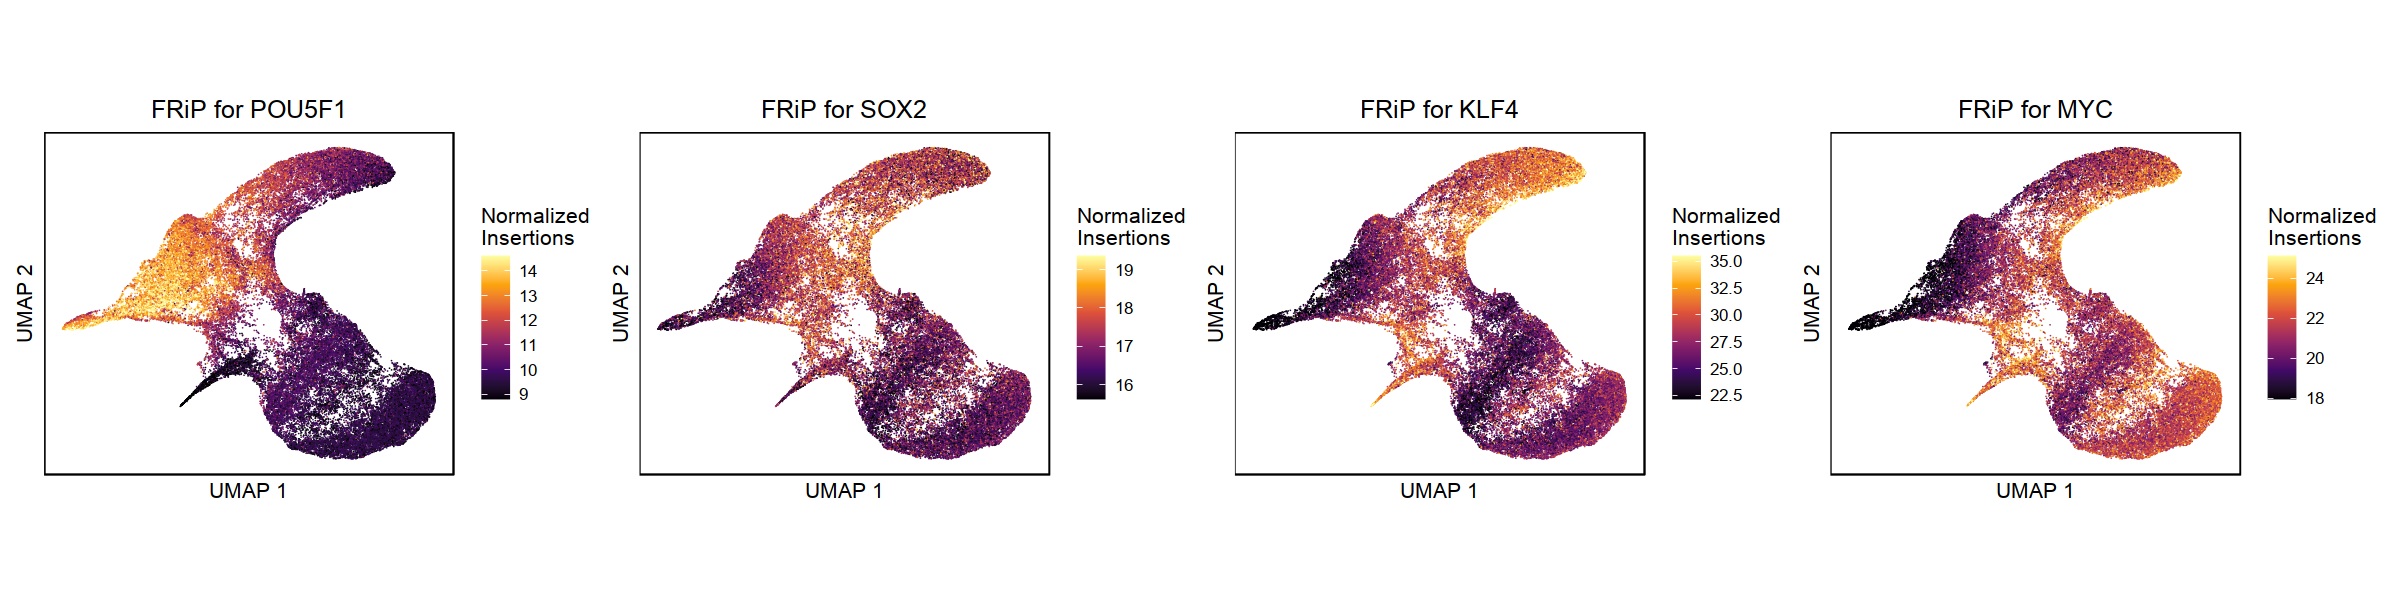

In [198]:
options(repr.plot.width = 20, repr.plot.height = 5)

frip_plots = list()

for (i in seq(ncol(motif_hits_matrix))) {
    cur_pattern = colnames(motif_hits_matrix)[i]

    df = data.frame(metaData, n=frips[[i]])
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1]), ]

    cur_plot <- ggplot(df) +
        geom_point(size=0.2, stroke=0, alpha=1, aes(x=umap1 , y=umap2, col=n)) +
        scale_color_viridis_c(limit=c(quantile(frips[[i]], 0.05),
                                      quantile(frips[[i]], 0.98)), 
                              oob = squish, option="B",
                             name="Normalized\nInsertions") +
        theme_classic() +
        xlab("UMAP 1") + ylab("UMAP 2") +
        theme(plot.title = element_text(hjust = 0.5),
              text = element_text(size=12),
              axis.line=element_blank(),
              axis.text.x=element_blank(),
              axis.text.y=element_blank(),
              axis.ticks=element_blank(),
              panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
        ggtitle(sprintf("FRiP for %s", cur_pattern)) + 
        theme(plot.title = element_text(hjust = 0.5)) +
        coord_fixed()
    
    frip_plots[[i]] = cur_plot

}

wrap_plots(frip_plots, nrow=1)

---

In [ ]:
sessionInfo()